In [37]:
import pandas as pd
import numpy as np

from collections import OrderedDict, namedtuple
from itertools import product
import time
from IPython.display import display, clear_output
import json

import torch 
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F

In [38]:
train_url = "https://raw.githubusercontent.com/wehrley/Kaggle-Digit-Recognizer/master/train.csv"
df_train = pd.read_csv(train_url)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [39]:
test_url = 'https://raw.githubusercontent.com/wehrley/Kaggle-Digit-Recognizer/master/test.csv'
df_test = pd.read_csv(test_url)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [40]:
train_set = df_train[0:29400]
train = torch.tensor(np.array(train_set.iloc[:, 1:]), dtype=torch.torch.float32)
train_labels = torch.tensor(np.array(train_set.iloc[:, 0]), dtype=torch.int64)
val_set = df_train[29400:]
val = torch.tensor(np.array(val_set.iloc[:, 1:]), dtype=torch.float32)
val_labels = torch.tensor(np.array(val_set.iloc[:, 0]), dtype=torch.int64)

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [45]:
train.shape

torch.Size([29400, 784])

In [49]:
#network1 = nn.Sequential(
#    nn.Linear(in_features=28*28, out_features=10),
#    nn.Tanh())

#networks = {
#    'one_layer': network1, 
#}

params = OrderedDict(
    lr = [0.1, 0.001, 0.00001],
    batch_size = [20, 1000],
    device = ['cuda'],
    weight_decay = [0.0, 1.0, 10.0])
 #   network = list(networks.keys())
#)

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

class RunManager():
    def __init__(self):
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None
        
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        
        self.network = None

       
    def begin_run(self, run, network):
        self.run_start_time = time.time()
        
        self.epoch_count = 0
        self.run_params = run
        self.run_count += 1
        
        self.network = network
        
    def end_run(self):
        self.epoch_count = 0
    
    def begin_epoch(self):
        self.epoch_start_time = time.time()
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
    
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        loss = self.epoch_loss / len(train)
        accuracy = self.epoch_num_correct / len(train)

            
        results = OrderedDict()
        results["run"] = self.run_count
        results['epoch'] = self.epoch_count
        results['loss'] = loss
        results['accuracy'] = accuracy
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration
        for k, v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient='columns')
        clear_output(wait=True)
        display(df)
    
    def track_loss(self, loss):
        self.epoch_loss += loss.item() * 10
    
    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
        
    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def save(self, fileName): # save in json and csv
        
        pd.DataFrame.from_dict(self.run_data, orient='columns').to_csv(f'{fileName}.csv')
        
        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

m = RunManager()
for run in RunBuilder.get_runs(params):
    network = nn.Sequential(nn.Linear(in_features=28*28, out_features=10), nn.Tanh()).to(device)
    mini_batches = [train[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    mini_labels = [train_labels[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    optimizer = optim.Adam(network.parameters(), lr=run.lr, weight_decay=run.weight_decay)

    m.begin_run(run, network)
    for epoch in range(40):
        m.begin_epoch()
        for b in range(0, len(mini_batches)):
            images = mini_batches[b].to(device)
            labels = mini_labels[b].to(device)
            preds = network(images) # pass batch
            loss = F.cross_entropy(preds, labels) # calculate loss
            optimizer.zero_grad() # zero gradients
            loss.backward() # calculate gradients
            optimizer.step() # update weights

            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        m.end_epoch()
    m.end_run()

pd.DataFrame.from_dict(m.run_data).sort_values('accuracy', ascending=False)[0:15]

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
0,1,1,1.149537,0.102381,1.334209,1.334209,0.10000,20,cuda,0.0
1,1,2,1.149474,0.102313,0.978331,2.325510,0.10000,20,cuda,0.0
2,1,3,1.149474,0.102313,0.941480,3.294919,0.10000,20,cuda,0.0
3,1,4,1.149474,0.102313,1.042214,4.361070,0.10000,20,cuda,0.0
4,1,5,1.149474,0.102313,0.949451,5.325494,0.10000,20,cuda,0.0
...,...,...,...,...,...,...,...,...,...,...
715,18,36,0.021907,0.174626,0.113696,3.861901,0.00001,1000,cuda,10.0
716,18,37,0.021487,0.180544,0.068816,3.964625,0.00001,1000,cuda,10.0
717,18,38,0.021028,0.188776,0.068818,4.063363,0.00001,1000,cuda,10.0
718,18,39,0.020594,0.197449,0.068815,4.167085,0.00001,1000,cuda,10.0


,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
599,15,40,0.490162,0.909932,1.707047,65.547149,0.00001,20,cuda,10.0
598,15,39,0.490231,0.909422,1.584567,63.795222,0.00001,20,cuda,10.0
597,15,38,0.490293,0.909422,1.808331,62.175749,0.00001,20,cuda,10.0
596,15,37,0.490371,0.909048,1.660057,60.334155,0.00001,20,cuda,10.0
595,15,36,0.490465,0.908878,1.864396,58.633207,0.00001,20,cuda,10.0
593,15,34,0.490687,0.908639,1.412663,55.247874,0.00001,20,cuda,10.0
594,15,35,0.490576,0.908605,1.458103,56.734900,0.00001,20,cuda,10.0
592,15,33,0.490815,0.908333,1.391282,53.802300,0.00001,20,cuda,10.0
591,15,32,0.490968,0.908061,1.672579,52.372123,0.00001,20,cuda,10.0
590,15,31,0.491150,0.907687,1.546391,50.667285,0.00001,20,cuda,10.0


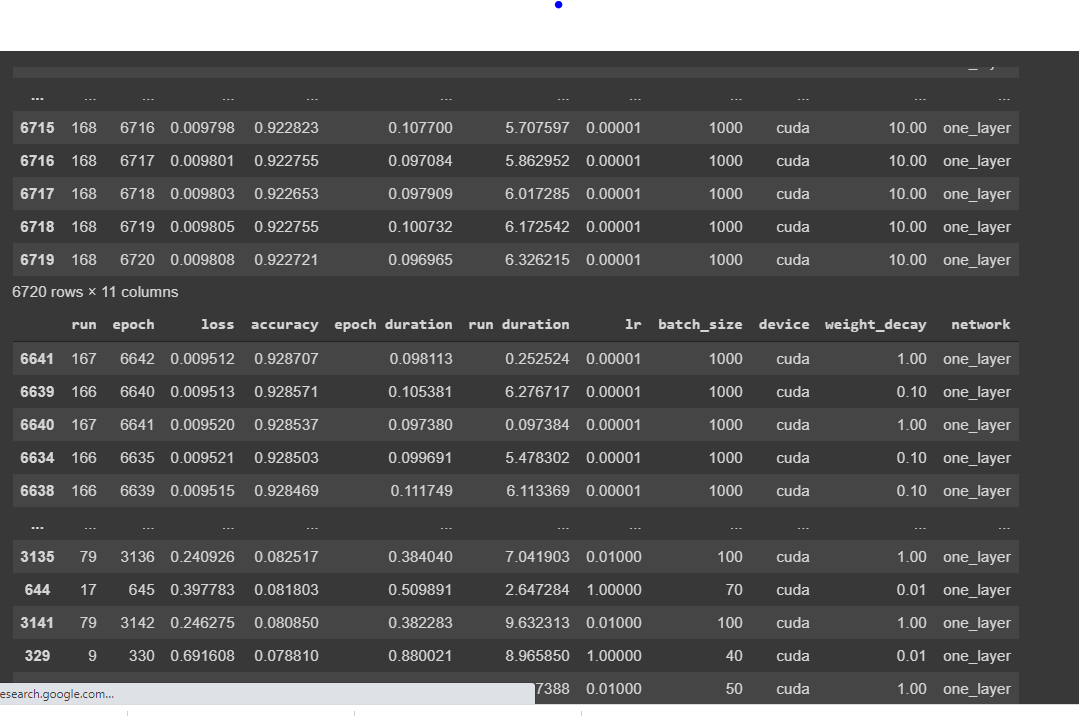

In [50]:
m.save('kaggle_mnist_fully_connected_no_hidden_tanh_v2')

In [51]:
train_labels.shape[0]

29400

In [52]:
len(train)

29400

In [53]:
batch_size = 20
learning_rate = 0.00001
weight_decay = 10.0
epochs = 70

model = nn.Sequential(
    nn.Linear(in_features=28*28, out_features=10),
    nn.Tanh())


model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
for j in range(epochs):
    num_correct = 0
    val_number_correct = 0
    mini_batches = [train[k:k + batch_size] for k in range(0, train_labels.shape[0], batch_size)]
    mini_labels = [train_labels[k:k + batch_size] for k in range(0, train_labels.shape[0], batch_size)]
    for b in range(0, len(mini_batches)):
        images = mini_batches[b].to(device)
        #print(images.shape)
        labels = mini_labels[b].to(device)
        #print(labels.shape)
        #print(labels.dtype)
        #print(images.dtype)
        preds = model(images)
        loss = F.cross_entropy(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_correct += preds.argmax(dim=1).eq(labels).sum().item()
    
    validation_set = val.to(device)
    validation_labels = val_labels.to(device) 
    validation_preds = model(validation_set)
    val_number_correct += validation_preds.argmax(dim=1).eq(validation_labels).sum().item()

    print('Completed epoch: ', j)
    print('Train accuracy: ', num_correct/len(train))
    print('Validation Accuracy: ', val_number_correct/len(validation_set))
    #scheduler.step()

Completed epoch:  0
Train accuracy:  0.20003401360544218
Validation Accuracy:  0.2966666666666667
Completed epoch:  1
Train accuracy:  0.41904761904761906
Validation Accuracy:  0.5054761904761905
Completed epoch:  2
Train accuracy:  0.5533333333333333
Validation Accuracy:  0.586031746031746
Completed epoch:  3
Train accuracy:  0.6209523809523809
Validation Accuracy:  0.6456349206349207
Completed epoch:  4
Train accuracy:  0.6843537414965987
Validation Accuracy:  0.7346825396825397
Completed epoch:  5
Train accuracy:  0.756156462585034
Validation Accuracy:  0.7761111111111111
Completed epoch:  6
Train accuracy:  0.7985714285714286
Validation Accuracy:  0.8165079365079365
Completed epoch:  7
Train accuracy:  0.8284013605442176
Validation Accuracy:  0.8357142857142857
Completed epoch:  8
Train accuracy:  0.8487755102040816
Validation Accuracy:  0.8527777777777777
Completed epoch:  9
Train accuracy:  0.8608163265306122
Validation Accuracy:  0.8630952380952381
Completed epoch:  10
Train acc

### tanh 
val 90.6% train 91.2%
- batch_size = 20
- learning_rate = 0.00001
- weight_decay = 10.0
- epochs = 40 (70 doesn't improve)